In [1]:
from collections import Counter
from dataset_formatted import df
from collections import defaultdict
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import pandas as pd
import tldextract
import numpy as np
from sklearn.preprocessing import LabelEncoder

### <span style="color:lightgreen">Basic Statistics & Summary of the Data:</span> 



In [2]:
df.info()
# 1. Check the fields that don't have 600 non-null values and decide how we want to handle these.

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 599
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Question                         500 non-null    object 
 1   Question Category                500 non-null    object 
 2   LLM                              500 non-null    object 
 3   Attributed Sources               366 non-null    object 
 4   Number of Sources                485 non-null    float64
 5   Are All Source Links Functional  368 non-null    object 
 6   Multi-modal Response             484 non-null    object 
dtypes: float64(1), object(6)
memory usage: 31.2+ KB


### <span style="color:lightgreen">EDA 1:</span>  <span style="color:lightgreen">Total Number of Sources by Model & Average Number of Sources by Model Per Question<span>



In [3]:
total_number_of_sources_by_model = df.groupby('LLM')['Number of Sources'].sum()
avg_number_of_sources_by_model_per_question= df.groupby('LLM')['Number of Sources'].sum() / 100
print(f'\nTotal Number of Sources by Model \n\n{total_number_of_sources_by_model}', '\n\n')
print(f'Average Number of Sources Per Question by Model \n\n{avg_number_of_sources_by_model_per_question}')



Total Number of Sources by Model 

LLM
chatGPT       944.0
copilot        55.0
gemini        315.0
llama          30.0
perplexity    648.0
Name: Number of Sources, dtype: float64 


Average Number of Sources Per Question by Model 

LLM
chatGPT       9.44
copilot       0.55
gemini        3.15
llama         0.30
perplexity    6.48
Name: Number of Sources, dtype: float64


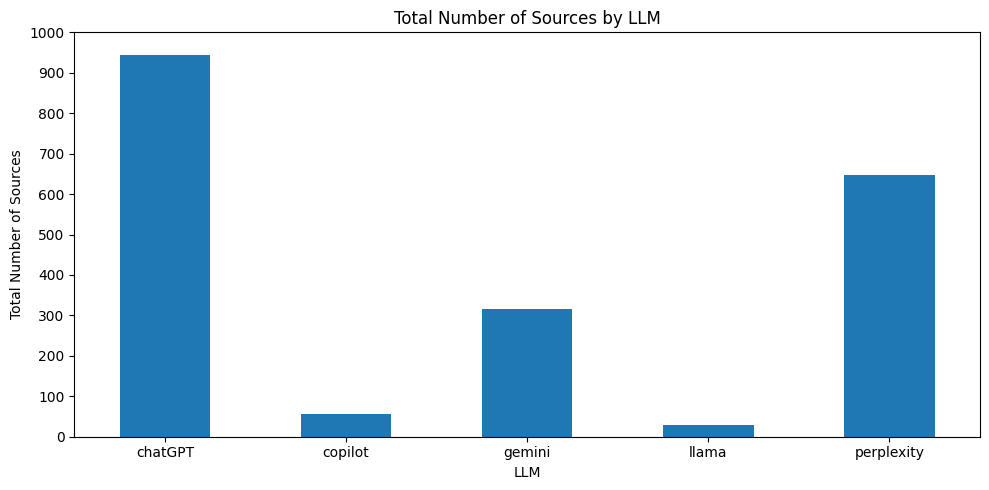

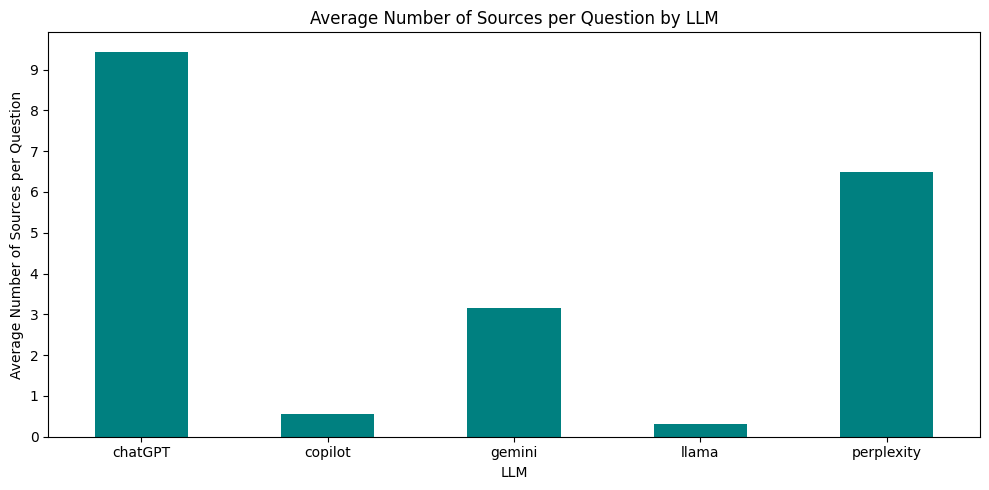

In [4]:
fig, ax1 = plt.subplots(figsize=(10, 5))
total_number_of_sources_by_model.plot(kind='bar', ax=ax1, title='Total Number of Sources by LLM')
ax1.set_ylabel('Total Number of Sources')
ax1.set_xlabel('LLM')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.set_yticks(range(0, int(total_number_of_sources_by_model.max()) + 100, 100))
plt.tight_layout()
plt.show()

fig, ax2 = plt.subplots(figsize=(10, 5))
avg_number_of_sources_by_model_per_question.plot(kind='bar', ax=ax2, color='teal', title='Average Number of Sources per Question by LLM')
ax2.set_ylabel('Average Number of Sources per Question')
ax2.set_xlabel('LLM')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.set_yticks(range(0, int(avg_number_of_sources_by_model_per_question.max()) + 1, 1))
plt.tight_layout()
plt.show()


### <span style="color:lightgreen">EDA 2:</span>  <span style="color:lightgreen">Exploration of Source Characteristics<span>

In [5]:
df.groupby('Question Category')['Question'].count()

Question Category
Economics & Commerce     35
Entertainment           125
Food & Cooking           15
General Knowledge        15
Geography                25
History                  90
Literature               25
Philosophy               15
Politics                 25
Science & Technology     85
Sports                   45
Name: Question, dtype: int64

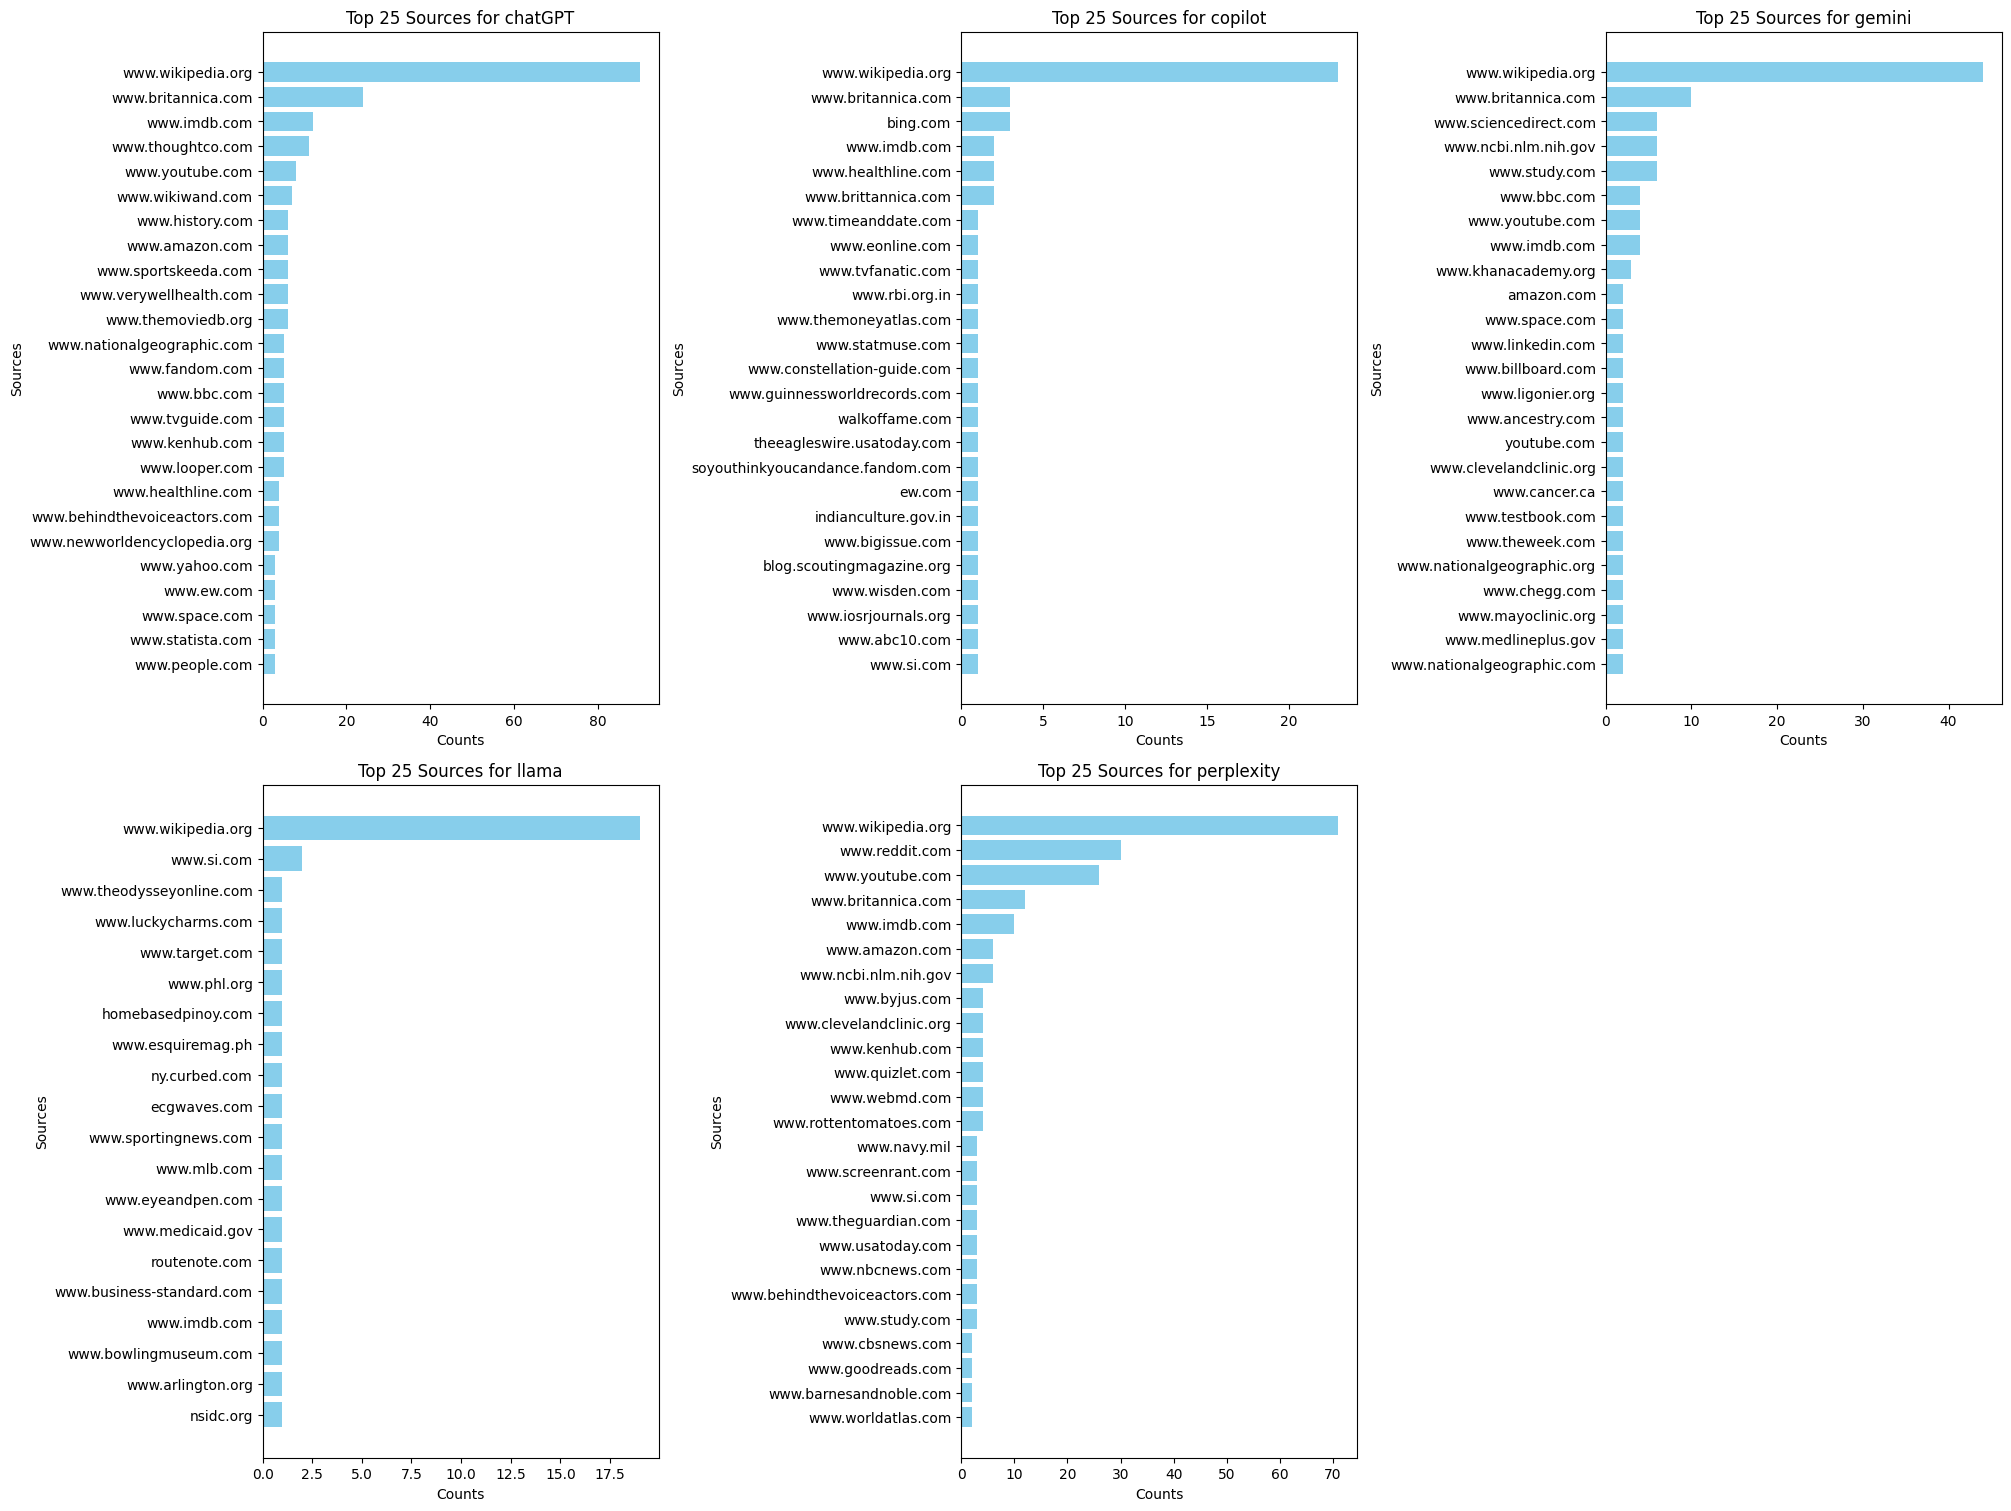

In [6]:
df_links = df.__deepcopy__()

df_links_grouped = df_links.groupby('LLM')['Attributed Sources'].apply(lambda x: ','.join(x.dropna()).split(','))

llm_link_counts = {}

for llm, links in df_links_grouped.items():
    flattened_link_list = [link.strip() for link in links]
    link_counts = Counter(flattened_link_list)
    llm_link_counts[llm] = link_counts

fig, axes = plt.subplots(2, 3, figsize=(20, 15), constrained_layout=True)
axes = axes.flatten()

plot_count = 0

for llm, counts in llm_link_counts.items():
    top_25_links = counts.most_common(25)
    links, counts = zip(*top_25_links)
    
    ax = axes[plot_count]
    ax.barh(links, counts, color='skyblue')
    ax.set_xlabel('Counts')
    ax.set_ylabel('Sources')
    ax.set_title(f'Top 25 Sources for {llm}')
    ax.invert_yaxis()  
    plot_count += 1

for i in range(plot_count, len(axes)):
    fig.delaxes(axes[i])

plt.show()



### <span style="color:lightgreen">EDA 3:</span>  <span style="color:lightgreen">Exploration of Top Level Domains (TLDs) & Creation of Additional Feature Columns to Dataset<span>

In [7]:
df_links_formatting_tld = df.__deepcopy__()

Top 10 TLDs Across All Models: 

[('com', 1189), ('org', 510), ('gov', 107), ('edu', 39), ('in', 25), ('net', 23), ('com ', 19), ('co', 17), ('uk', 14), ('au', 8)]


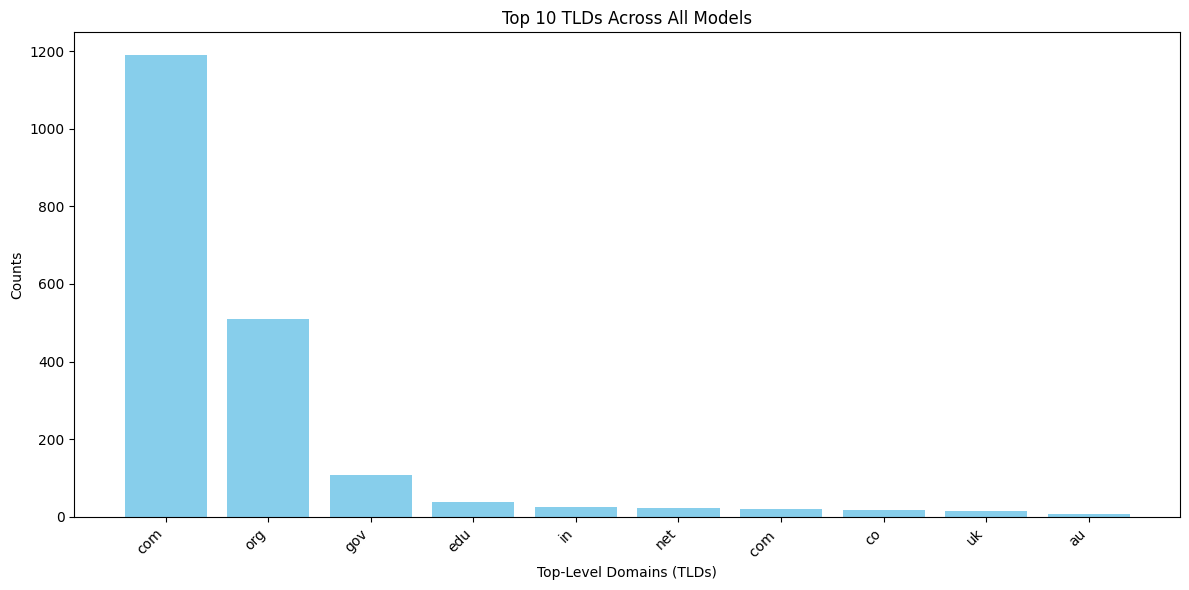

In [8]:
tld_counts = {}

for key, links in df_links_grouped.items():
    for link in links:
        if not link: 
            continue
        if not link.startswith(('https://')):
            link = 'https://' + link  
        domain = urlparse(link).netloc
        if not domain:
            continue
        tld = domain.split('.')[-1]
        if tld in tld_counts:
            tld_counts[tld] += 1
        else:
            tld_counts[tld] = 1

top_10_tlds = sorted(tld_counts.items(), key=lambda item: item[1], reverse=True)[:10]
print(f'Top 10 TLDs Across All Models: \n\n{top_10_tlds}')
tlds, counts = zip(*top_10_tlds)

plt.figure(figsize=(12, 6))
plt.bar(tlds, counts, color='skyblue')
plt.xlabel('Top-Level Domains (TLDs)')
plt.ylabel('Counts')
plt.title('Top 10 TLDs Across All Models')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [9]:
new_columns = ['.com count', '.org count', '.gov count', '.edu count', 'other count']
positions = [5, 6, 7, 8, 9]

for col, pos in zip(new_columns, positions):
    df_links_formatting_tld.insert(pos, col, 0)


def count_tlds(row):
    tld_counts = {
        '.com': 0,
        '.org': 0,
        '.gov': 0,
        '.edu': 0,
        'other': 0
    }
    links = row.split(', ')
    for link in links:
        link = link.strip()
        if not link.startswith(('http://', 'https://')):
            link = 'http://' + link
        tld_info = tldextract.extract(link)
        tld = '.' + tld_info.suffix
        if tld in tld_counts:
            tld_counts[tld] += 1
    return pd.Series(tld_counts)

df_links_formatting_tld['Attributed Sources'] = df_links_formatting_tld['Attributed Sources'].fillna('')
df_links_formatting_tld[['.com count', '.org count', '.gov count', '.edu count', 'other count']] = df_links_formatting_tld['Attributed Sources'].apply(count_tlds)

df_links_formatting_tld.head()

# df_links_formatting_tld.to_csv('df_links_formatting_tld.csv', index=False)

,Question,Question Category,LLM,Attributed Sources,Number of Sources,.com count,.org count,.gov count,.edu count,other count,Are All Source Links Functional,Multi-modal Response
0,"""where does the saying keeping up with the jon...",General Knowledge,gemini,"www.commonlit.org, www.history.howstuffworks.com",2.0,1,1,0,0,0,all_links_functional,text_only
1,"""when did day light savings start in the us""",History,gemini,www.wikipedia.org,1.0,0,1,0,0,0,all_links_functional,text_only
2,"""what is the doll in the garden about""",Entertainment,gemini,"www.goodreads.com, amazon.com, www.publishersw...",3.0,3,0,0,0,0,all_links_functional,text_only
3,"""where is a unitary system of government found""",Politics,gemini,"www.britannica.com, www.guides.skylinecollege....",3.0,1,1,0,1,0,all_links_functional,text_only
4,"""who dies in season 2 of the originals""",Entertainment,gemini,www.wikipedia.org,1.0,0,1,0,0,0,all_links_functional,text_only


### <span style="color:lightgreen">Development of Trust Score:</span> 

In [10]:
df_trust_score = df_links_formatting_tld.__deepcopy__()

df_trust_score['Multi-modal Response'] = df_trust_score['Multi-modal Response'].fillna('text_only')

df_trust_score.insert(12, 'Trust Score', 0)

for index, r in df_trust_score.iterrows():
    trust_score = 0
    if r['Number of Sources'] > 0:
        trust_score += 5
    # if r['.com count'] > 0:
    #     trust_score += (r['.com count'] * 1)
    # if r['.org count'] > 0:
    #     trust_score += (r['.org count'] * 1)
    # if r['.gov count'] > 0:
    #     trust_score += (r['.gov count'] * 1)
    # if r['.edu count'] > 0:
    #     trust_score += (r['.edu count'] * 1)
    if r['Are All Source Links Functional'] == 'all_links_functional':
        trust_score += 2
    elif r['Are All Source Links Functional'] == 'some_links_funcitonal':
        trust_score += 1
    if r['Attributed Sources'] != '':
        unique_sources = set(r['Attributed Sources'].split(', '))
        trust_score += len(unique_sources)
    if r['Multi-modal Response'] == 'multi-modal':
        trust_score += 2
    elif r['Multi-modal Response'] == 'text_only':
        trust_score += 1

    df_trust_score.at[index, 'Trust Score'] = trust_score

df_trust_score.head()


,Question,Question Category,LLM,Attributed Sources,Number of Sources,.com count,.org count,.gov count,.edu count,other count,Are All Source Links Functional,Multi-modal Response,Trust Score
0,"""where does the saying keeping up with the jon...",General Knowledge,gemini,"www.commonlit.org, www.history.howstuffworks.com",2.0,1,1,0,0,0,all_links_functional,text_only,10
1,"""when did day light savings start in the us""",History,gemini,www.wikipedia.org,1.0,0,1,0,0,0,all_links_functional,text_only,9
2,"""what is the doll in the garden about""",Entertainment,gemini,"www.goodreads.com, amazon.com, www.publishersw...",3.0,3,0,0,0,0,all_links_functional,text_only,11
3,"""where is a unitary system of government found""",Politics,gemini,"www.britannica.com, www.guides.skylinecollege....",3.0,1,1,0,1,0,all_links_functional,text_only,11
4,"""who dies in season 2 of the originals""",Entertainment,gemini,www.wikipedia.org,1.0,0,1,0,0,0,all_links_functional,text_only,9


In [11]:
mean_by_model = df_trust_score.groupby('LLM')['Trust Score'].mean()
print(f'Mean Trust Score by Model: \n\n{mean_by_model}')

Mean Trust Score by Model: 

LLM
chatGPT       16.46
copilot        5.66
gemini         9.96
llama          3.49
perplexity    15.28
Name: Trust Score, dtype: float64


In [12]:
# feature_columns = df_trust_score.columns.difference(['Trust Score', 'Attributed Sources', 'Question'])

# fig, axes = plt.subplots(len(feature_columns), 1, figsize=(20, len(feature_columns) * 5))
# axes = axes.flatten()

# for ax, feature in zip(axes, feature_columns):
#     ax.scatter(df_trust_score[feature].astype(str), df_trust_score['Trust Score'], alpha=0.5)
#     ax.set_xlabel(feature)
#     ax.set_ylabel('Trust Score')
#     ax.set_title(f'{feature} vs. Trust Score')
#     ax.tick_params(axis='x', rotation=0)

# plt.subplots_adjust(hspace=0.5)
# plt.show()

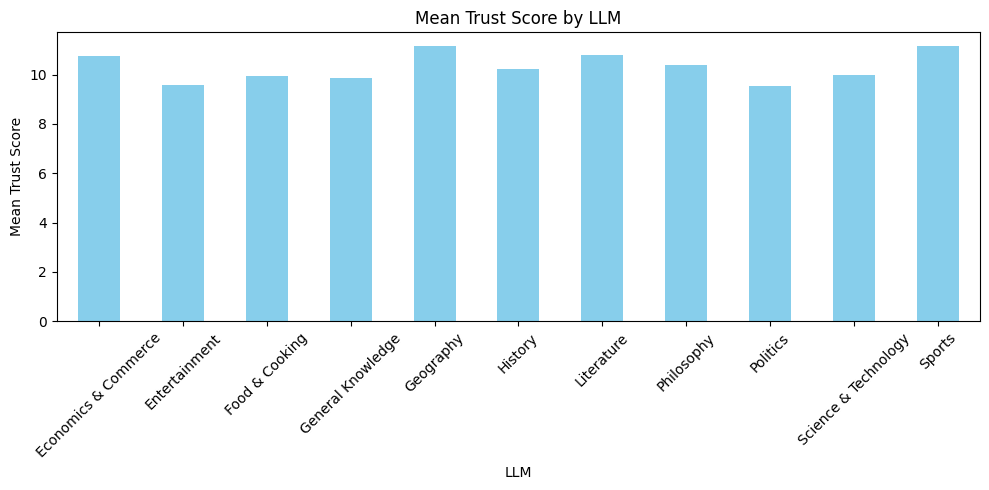

In [13]:
plt.figure(figsize=(10, 5))
df_trust_score.groupby('Question Category')['Trust Score'].mean().plot(kind='bar', color='skyblue')
plt.xlabel('LLM')
plt.ylabel('Mean Trust Score')
plt.title('Mean Trust Score by LLM')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
encoder = LabelEncoder()
encoded_LLMs = encoder.fit_transform(df_trust_score['LLM'])
df_trust_score['LLM'] = encoded_LLMs + 1

encoded_question_categories = encoder.fit_transform(df_trust_score['Question Category'])
df_trust_score['Question Category'] = encoded_question_categories + 1

df_trust_score = pd.get_dummies(df_trust_score, columns=['Are All Source Links Functional', 'Multi-modal Response'], drop_first=True).fillna(0)

numeric_columns = df_trust_score.select_dtypes(include=[np.number, 'bool']).columns
df_trust_score[numeric_columns] = df_trust_score[numeric_columns].astype(int)

df_trust_score.head()

,Question,Question Category,LLM,Attributed Sources,Number of Sources,.com count,.org count,.gov count,.edu count,other count,Trust Score,Are All Source Links Functional_no_links_functional,Are All Source Links Functional_some_links_functional,Multi-modal Response_text_only
0,"""where does the saying keeping up with the jon...",4,3,"www.commonlit.org, www.history.howstuffworks.com",2,1,1,0,0,0,10,0,0,1
1,"""when did day light savings start in the us""",6,3,www.wikipedia.org,1,0,1,0,0,0,9,0,0,1
2,"""what is the doll in the garden about""",2,3,"www.goodreads.com, amazon.com, www.publishersw...",3,3,0,0,0,0,11,0,0,1
3,"""where is a unitary system of government found""",9,3,"www.britannica.com, www.guides.skylinecollege....",3,1,1,0,1,0,11,0,0,1
4,"""who dies in season 2 of the originals""",2,3,www.wikipedia.org,1,0,1,0,0,0,9,0,0,1


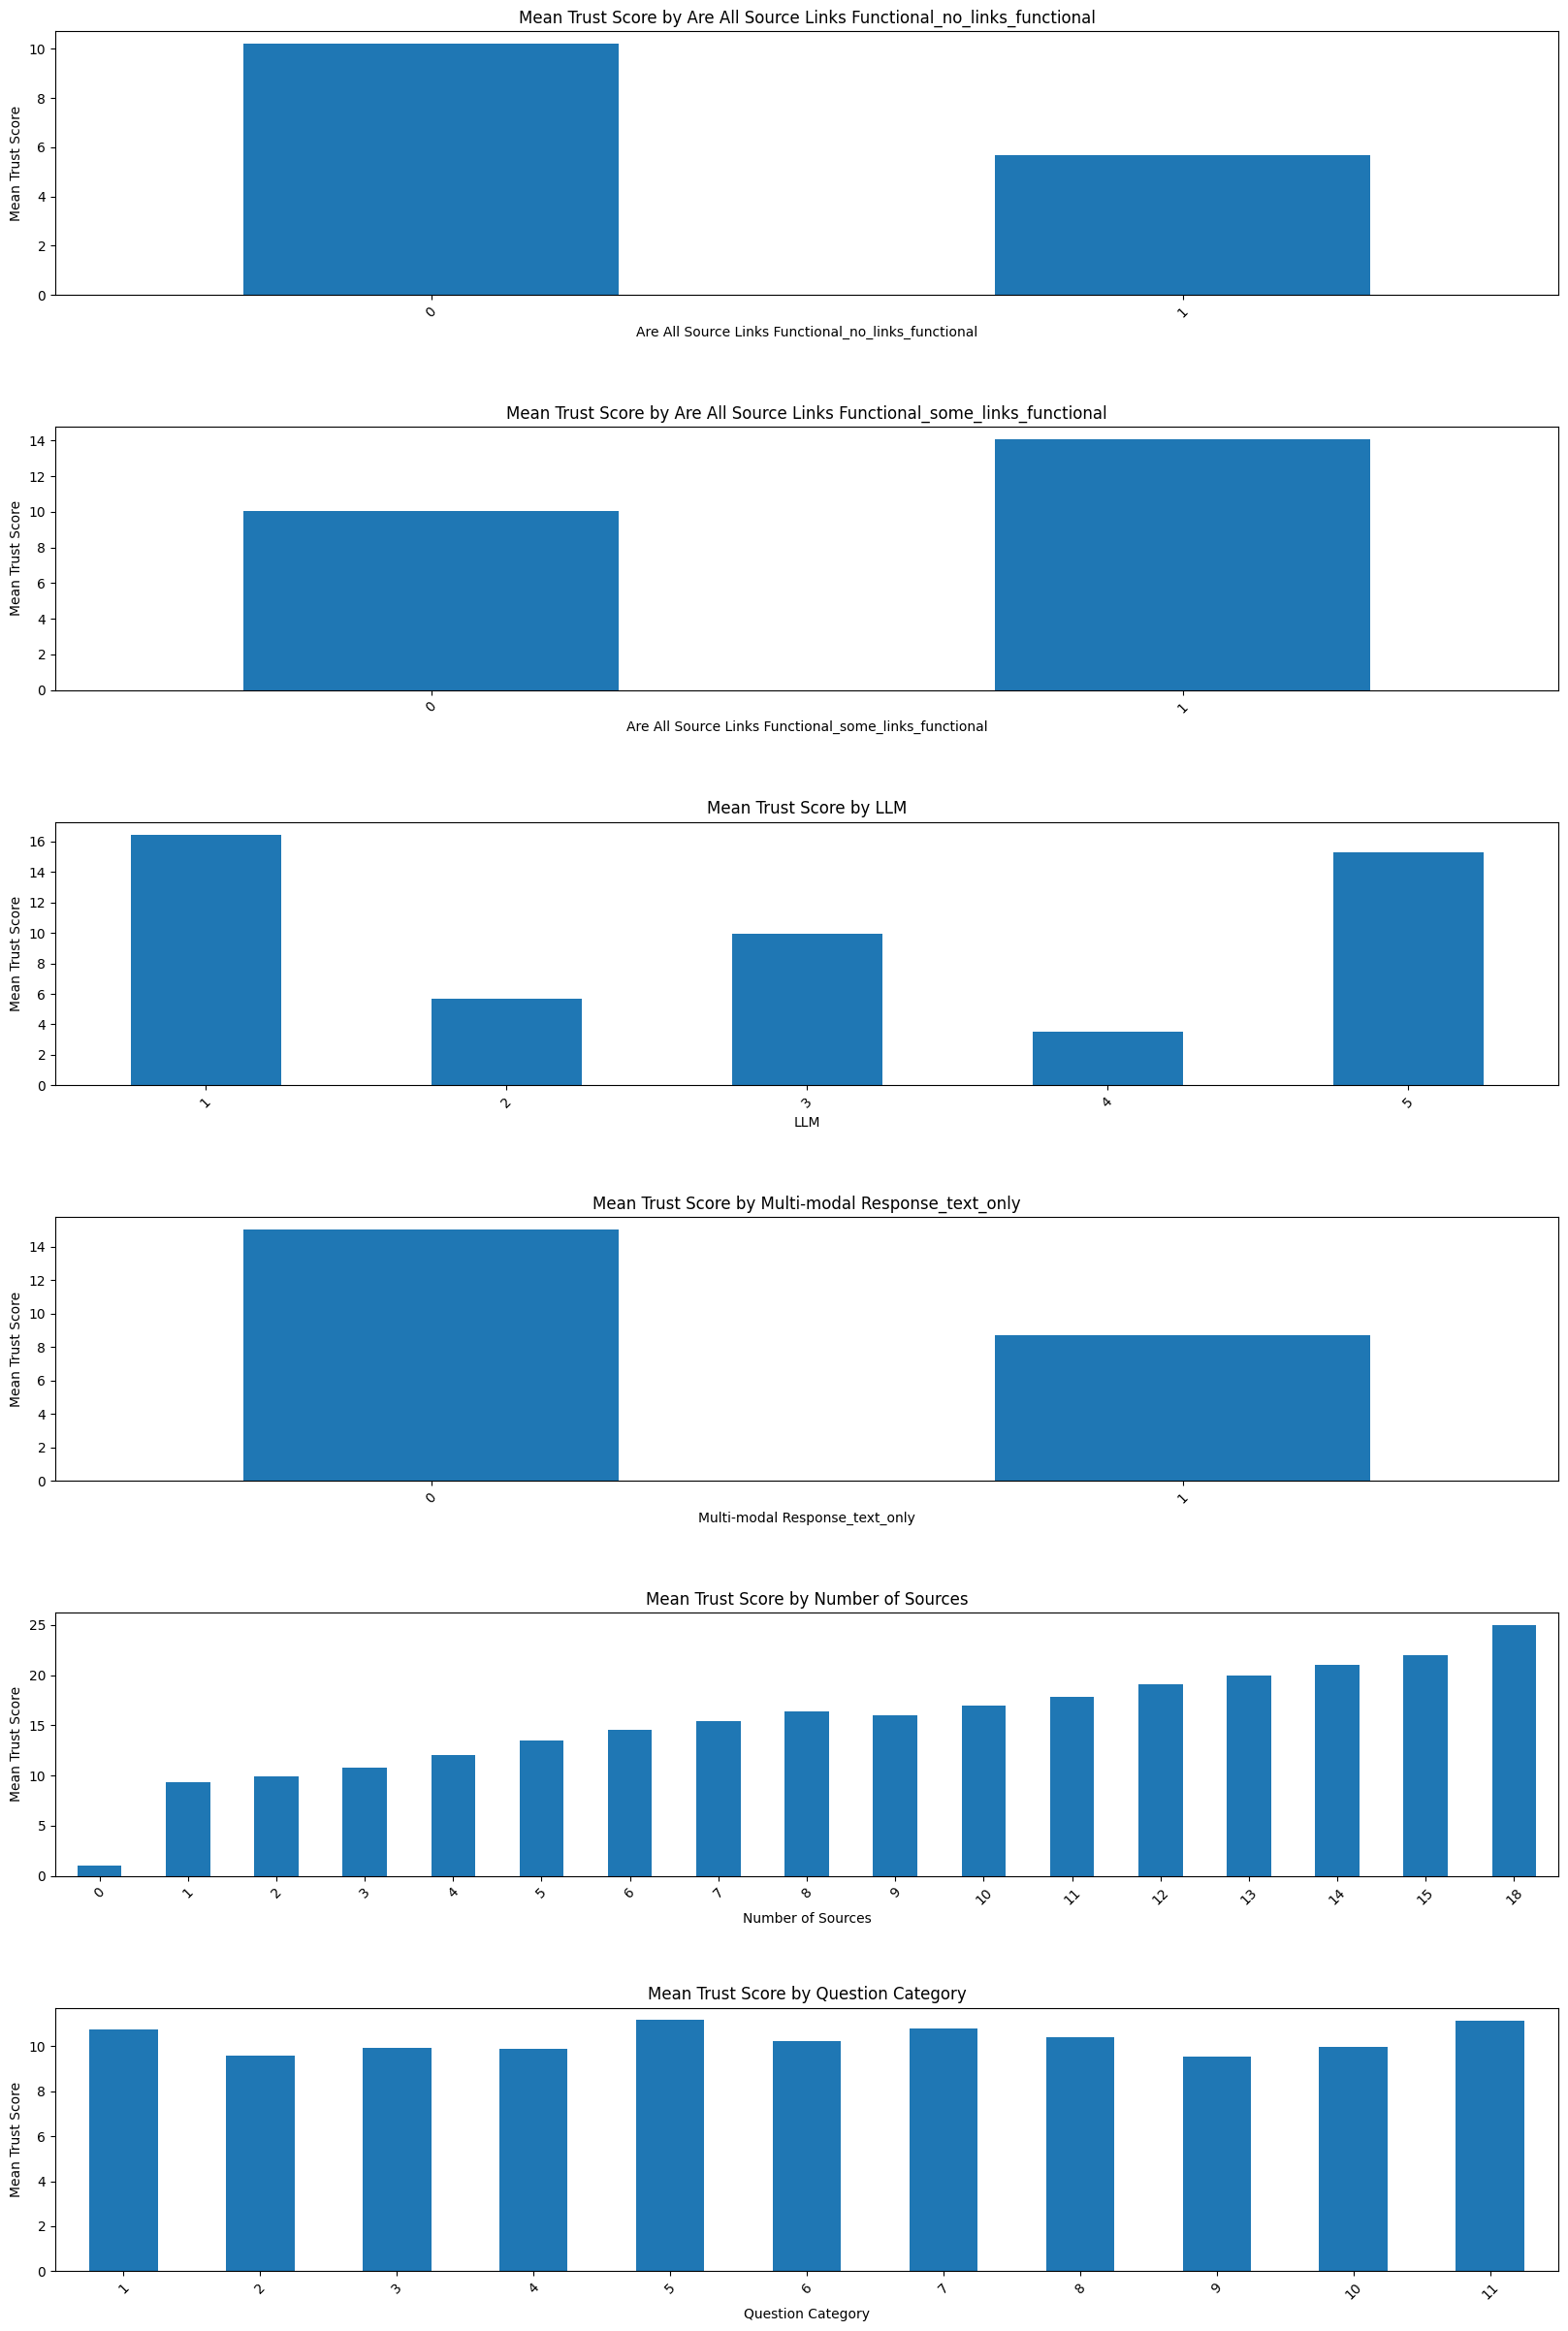

In [15]:
feature_columns2 = df_trust_score.columns.difference(['Trust Score', 'Attributed Sources', 'Question', '.com count', '.org count', '.gov count', '.edu count', 'other count'])

fig, axes = plt.subplots(len(feature_columns2), 1, figsize=(20, len(feature_columns2) * 5))
axes = axes.flatten()

for ax, feature in zip(axes, feature_columns2):
    df_trust_score.groupby(feature)['Trust Score'].mean().plot(kind='bar', ax=ax)
    ax.set_xlabel(feature)
    ax.set_ylabel('Mean Trust Score')
    ax.set_title(f'Mean Trust Score by {feature}')
    ax.tick_params(axis='x', rotation=45)

plt.subplots_adjust(hspace=0.5)
plt.show()

In [16]:
df_questions_analysis = df_trust_score.__deepcopy__()

In [17]:
df_questions_analysis.head()

,Question,Question Category,LLM,Attributed Sources,Number of Sources,.com count,.org count,.gov count,.edu count,other count,Trust Score,Are All Source Links Functional_no_links_functional,Are All Source Links Functional_some_links_functional,Multi-modal Response_text_only
0,"""where does the saying keeping up with the jon...",4,3,"www.commonlit.org, www.history.howstuffworks.com",2,1,1,0,0,0,10,0,0,1
1,"""when did day light savings start in the us""",6,3,www.wikipedia.org,1,0,1,0,0,0,9,0,0,1
2,"""what is the doll in the garden about""",2,3,"www.goodreads.com, amazon.com, www.publishersw...",3,3,0,0,0,0,11,0,0,1
3,"""where is a unitary system of government found""",9,3,"www.britannica.com, www.guides.skylinecollege....",3,1,1,0,1,0,11,0,0,1
4,"""who dies in season 2 of the originals""",2,3,www.wikipedia.org,1,0,1,0,0,0,9,0,0,1


In [18]:
# Function to determine the interrogatory type
def identify_interrogatory(question):
    interrogatories = ['where', 'why', 'what', 'who', 'how', 'when', 'which', 'describe', 'list', 'for which']
    question_lower = question.lower()
    for interrogatory in interrogatories:
        if f"{interrogatory} " in question_lower or question_lower.startswith(interrogatory):
            return interrogatory.capitalize()
    return None  # If no interrogative word is found

# Apply the function to create the Interrogatory column
df_questions_analysis['Interrogatory'] = df_questions_analysis['Question'].apply(identify_interrogatory)

# Display the dataframe to verify the results
df_questions_analysis

,Question,Question Category,LLM,Attributed Sources,Number of Sources,.com count,.org count,.gov count,.edu count,other count,Trust Score,Are All Source Links Functional_no_links_functional,Are All Source Links Functional_some_links_functional,Multi-modal Response_text_only,Interrogatory
0,"""where does the saying keeping up with the jon...",4,3,"www.commonlit.org, www.history.howstuffworks.com",2,1,1,0,0,0,10,0,0,1,Where
1,"""when did day light savings start in the us""",6,3,www.wikipedia.org,1,0,1,0,0,0,9,0,0,1,When
2,"""what is the doll in the garden about""",2,3,"www.goodreads.com, amazon.com, www.publishersw...",3,3,0,0,0,0,11,0,0,1,What
3,"""where is a unitary system of government found""",9,3,"www.britannica.com, www.guides.skylinecollege....",3,1,1,0,1,0,11,0,0,1,Where
4,"""who dies in season 2 of the originals""",2,3,www.wikipedia.org,1,0,1,0,0,0,9,0,0,1,Who
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,"""who is the author of the book arabian nights?""",7,1,"www.newworldencyclopedia.org, www.britannica.c...",10,5,3,1,0,0,17,0,0,1,Who
596,"""who is the voice of tony the tiger?""",1,1,"people.com, www.omahamagazine.com,www.wikipedi...",9,6,2,0,0,0,16,0,0,1,Who
597,"""who lives in the imperial palace in tokyo?""",6,1,"sankan.kunaicho.go.jp, www.japanmanifest.com, ...",11,6,1,0,0,0,18,0,0,1,Who
598,"""who played will on as the world turns?""",2,1,"www.wikipedia.org, www.looper.com, www.soapcen...",6,5,1,0,0,0,14,0,0,1,Who


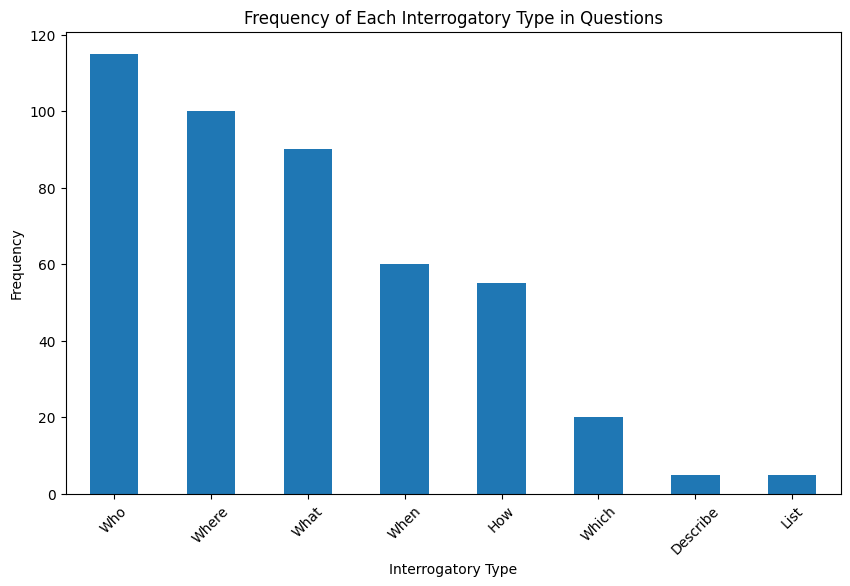

In [19]:
# Plotting the frequencies of each unique value in the Interrogatory column
plt.figure(figsize=(10, 6))
df_questions_analysis['Interrogatory'].value_counts().plot(kind='bar')
plt.xlabel('Interrogatory Type')
plt.ylabel('Frequency')
plt.title('Frequency of Each Interrogatory Type in Questions')
plt.xticks(rotation=45)
plt.show()

In [20]:
# Calculating the mean Trust Score for each Interrogatory type
mean_trust_score_by_interrogatory = df_questions_analysis.groupby('Interrogatory')['Trust Score'].mean()

print(mean_trust_score_by_interrogatory)

Interrogatory
Describe    11.200000
How         10.127273
List        11.000000
What         9.700000
When         9.933333
Where       10.410000
Which       10.800000
Who         10.530435
Name: Trust Score, dtype: float64


In [21]:
# Calculating the mean Number of Sources for each Interrogatory type
mean_sources_by_interrogatory = df_questions_analysis.groupby('Interrogatory')['Number of Sources'].mean()

print(mean_sources_by_interrogatory)

Interrogatory
Describe    6.000000
How         3.727273
List        4.400000
What        4.011111
When        3.900000
Where       4.150000
Which       4.600000
Who         3.817391
Name: Number of Sources, dtype: float64


In [22]:
# Rule-based classification for simplicity - objective/subjective
def classify_objective_subjective(question):
    subjective_keywords = ['why', 'think', 'feel', 'should', 'opinion']
    question_lower = question.lower()
    for keyword in subjective_keywords:
        if keyword in question_lower:
            return 'Subjective'
    return 'Objective'

# Apply the function to create the Objective/Subjective column
df_questions_analysis['Question Type'] = df_questions_analysis['Question'].apply(classify_objective_subjective)

# Displaying the result
df_questions_analysis

,Question,Question Category,LLM,Attributed Sources,Number of Sources,.com count,.org count,.gov count,.edu count,other count,Trust Score,Are All Source Links Functional_no_links_functional,Are All Source Links Functional_some_links_functional,Multi-modal Response_text_only,Interrogatory,Question Type
0,"""where does the saying keeping up with the jon...",4,3,"www.commonlit.org, www.history.howstuffworks.com",2,1,1,0,0,0,10,0,0,1,Where,Objective
1,"""when did day light savings start in the us""",6,3,www.wikipedia.org,1,0,1,0,0,0,9,0,0,1,When,Objective
2,"""what is the doll in the garden about""",2,3,"www.goodreads.com, amazon.com, www.publishersw...",3,3,0,0,0,0,11,0,0,1,What,Objective
3,"""where is a unitary system of government found""",9,3,"www.britannica.com, www.guides.skylinecollege....",3,1,1,0,1,0,11,0,0,1,Where,Objective
4,"""who dies in season 2 of the originals""",2,3,www.wikipedia.org,1,0,1,0,0,0,9,0,0,1,Who,Objective
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,"""who is the author of the book arabian nights?""",7,1,"www.newworldencyclopedia.org, www.britannica.c...",10,5,3,1,0,0,17,0,0,1,Who,Objective
596,"""who is the voice of tony the tiger?""",1,1,"people.com, www.omahamagazine.com,www.wikipedi...",9,6,2,0,0,0,16,0,0,1,Who,Objective
597,"""who lives in the imperial palace in tokyo?""",6,1,"sankan.kunaicho.go.jp, www.japanmanifest.com, ...",11,6,1,0,0,0,18,0,0,1,Who,Objective
598,"""who played will on as the world turns?""",2,1,"www.wikipedia.org, www.looper.com, www.soapcen...",6,5,1,0,0,0,14,0,0,1,Who,Objective


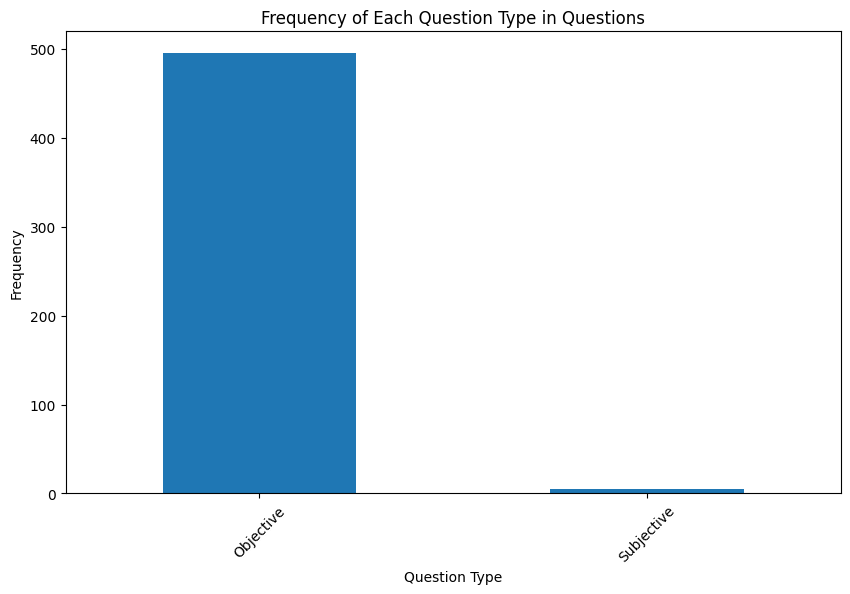

In [23]:
# Plotting the frequencies of each unique value in the Interrogatory column
plt.figure(figsize=(10, 6))
df_questions_analysis['Question Type'].value_counts().plot(kind='bar')
plt.xlabel('Question Type')
plt.ylabel('Frequency')
plt.title('Frequency of Each Question Type in Questions')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# from transformers import pipeline

# # classifier_sent = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
# classifier_zero_shot = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# # Define intent categories
# intent_labels = ["informational", "procedural", "opinion-based", "emotional"]

# # Apply zero-shot classification to each question and get the highest scoring intent
# df_questions_analysis['Intent'] = df_questions_analysis['Question'].apply(
#     lambda x: classifier_zero_shot(x, candidate_labels=intent_labels)['labels'][0]
# )

# # Display the DataFrame with classified intents
# df_questions_analysis

# I read about a few pre-trained text classifiers and tried to use some of them but couldn't get the right combination 
# of packages or supporting software or whatever configured on my local machine and at some point just 
# gave up exploring this option to focus time on other options.